## Modelowanie układów przepływowych - ćwiczenia
#### (metoda super-kropelek)
Sylwester Arabas (sylwester.arabas@agh.edu.pl) & Emma Ware (ecware@ucdavis.edu) 

---
### 0. Równanie Smoluchowskiego
- [Koagulacja (Coagulation)](https://en.wikipedia.org/wiki/Coagulation_&#40;disambiguation&#41;) - wzrost cząsteczek przez agregację
- [Równanie Smoluchowskiego (Smoluchowski coagulation equation - SCE)](https://en.wikipedia.org/wiki/Smoluchowski_coagulation_equation)

Deterministyczny model opisujący ewolucję rozkładu mas cząstek:
  $$
  \frac{\partial c(x,t)}{\partial t} = \frac{1}{2} \int_0^x K(y, x - y) c(x-y,t) c(y,t) \, dy -\int_0^\infty K(y,x) n(x,t) n(y,t) \, dy
  $$
  gdzie $K(x_1, x_2)$ to jądro koagulacji.

---
### Rozwiązanie analityczne [Safranov 1962](https://www.mathnet.ru/rus/dan27172)/[Golovin 1963](http://mi.mathnet.ru/dan27630)

$K(x_1,x_2) = b\cdot(x_1 + x_2)$,

$\tau = 1 - e^{-\,n_0\, b\, x_0\, t},$

$$
f(x,t)
=
\frac{1-\tau}{x \sqrt{\tau}}
\, I_{1}\left(\frac{2x}{x_0}\sqrt{\tau}\right)
\exp\left[-\frac{(1+\tau - 2\sqrt{\tau})\, x}{x_0}\right],
$$

gdzie $I_{1}$ - [funkcja Bessela](https://en.wikipedia.org/wiki/Bessel_function).

### 1. potrzebne pakiety

In [1]:
""" targetting 100% nbqa-pylint clean code! :) """

from types import SimpleNamespace
from functools import partial
from copy import deepcopy
import numpy as np
import scipy
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

### 2. Parametry fizyczne i numeryczne



In [2]:
PARAMS_PHYS = SimpleNamespace(
    n0=2**23,
    dv_m3 = 1e6,
    b_per_s = 1.5e3,
)
PARAMS_PHYS.norm = PARAMS_PHYS.n0 * PARAMS_PHYS.dv_m3
PARAMS_PHYS.x0 = 1/PARAMS_PHYS.norm
PARAMS_PHYS.dist = scipy.stats.expon(loc=0, scale=PARAMS_PHYS.x0)

PARAMS_COMP = SimpleNamespace(
    n_part = 2**11,
    t_max_s = 3600,
    n_step = 1800,
    output_step = 100
)
PARAMS_COMP.dt_s = PARAMS_COMP.t_max_s / PARAMS_COMP.n_step

PARAMS_PLOT = SimpleNamespace(
    x_of_mass = lambda mass: np.log(mass) / 3,
    mass_of_x = lambda x: np.exp(3 * x),
    bins_x_range = (-12, -5),
    bins_count = 35,
)

RNG = np.random.default_rng(seed=44)

### 3. Rozwiązanie analityczne


In [3]:
def kernel(mass_1, mass_2, coeff):
    """ additive coagulation kernel """
    return coeff * (mass_1 + mass_2)

def analytic_solution(mass_kg, time_s, params_phys):
    """ Safranov/Golovin's analytic solution to Smoluchowski coagulation equation
    for additive kernel and exponential initial condition """
    tau = 1 - np.exp(-params_phys.n0 * params_phys.b_per_s * params_phys.x0 * time_s)
    sqrt_tau = np.sqrt(tau)
    return (
        (1 - tau) / (mass_kg * sqrt_tau)
        * scipy.special.ive(1, 2 * mass_kg / params_phys.x0 * sqrt_tau)  # pylint: disable=no-member
        * np.exp(-(1 + tau - 2 * sqrt_tau) * mass_kg / params_phys.x0)
    )


### 4. Funkcja próbkowania

In [4]:
def sample(*, params_comp, params_phys, rng):
    """ randomly samples a particle population using constant-multiplicity,
    uniform-mass and uniform-log-mass schemes and returns a dictionary
    of three simulation state, each composed of 'mass' and 'mult' arrays """
    u01 = rng.uniform(0, 1, size=params_comp.n_part)
    return {
        k: {
            'mass': v['x'],
            'mult': np.round(v['y'] * params_phys.norm).astype(int),
        }
        for k,v in
        {
            # TODO
            'sampling: constant multiplicity': {
                'x': params_phys.dist.ppf(u01),
                'y': np.full(shape=params_comp.n_part, fill_value=1 / params_comp.n_part),
            }
        }.items()
    }

### 5. Wizualizacja (stan początkowy)

In [5]:
def plot(step, *, output, params_phys, params_comp, params_plot, rng):
    """ plots the particle state as both a histogram and population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    particles = output[step]
    time = 1e-10 if step == 0 else step * params_comp.output_step * params_comp.dt_s
    fig, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(11, 6),
        sharex=True,
        layout='constrained',
    )
    scale = params_phys.norm / params_comp.n_part
    for k, part in particles.items():
        axs['hist'].hist(
            x=params_plot.x_of_mass(part['mass']),
            weights=part['mult'] / params_phys.norm * part['mass'],
            bins=params_plot.bins_count,
            range=params_plot.bins_x_range,
            label=f'{k}',
            alpha=.666,
            density=True,
        )
        scale =.1 + 2*(np.log10(particles[k]['mult']) - 2)
        axs['part'].scatter(
            params_plot.x_of_mass(particles[k]['mass']),
            rng.uniform(0, 1, params_comp.n_part),
            s=scale*.8,
            alpha=scale/max(scale)*.6,
            linewidths=0,
        )
    lin_x, d_x = np.linspace(*params_plot.bins_x_range, 256, retstep=True)
    x_mean = lin_x[:-1] + d_x / 2
    m_mean = params_plot.mass_of_x(x_mean)
    analytic_mass_dist = lambda mass, x: mass * params_phys.norm * analytic_solution(
        mass_kg=mass,
        time_s=time,
        params_phys=params_phys
    ) * np.diff(params_plot.mass_of_x(x)) / np.diff(x)
    axs['hist'].plot(
        x_mean,
        analytic_mass_dist(m_mean, lin_x),
        color='black',
        label='Safranov/Golovin solution'
    )
    axs['hist'].legend()
    axs['hist'].set(
        yticks=[],
        ylabel=r'pdf(x) $\cdot$ m(x)',
        title=f'time: {time:.0f} s',
        xlim=params_plot.bins_x_range,
        ylim=(0, 1.7)
    )

    axs['part'].set_xlabel(r'$x = ln(\sqrt[3]{m})$')
    axs['part'].set_yticks([])
    axs['part'].set_ylim(0,1)
    for axes in axs.values():
        axes.grid()
    return fig

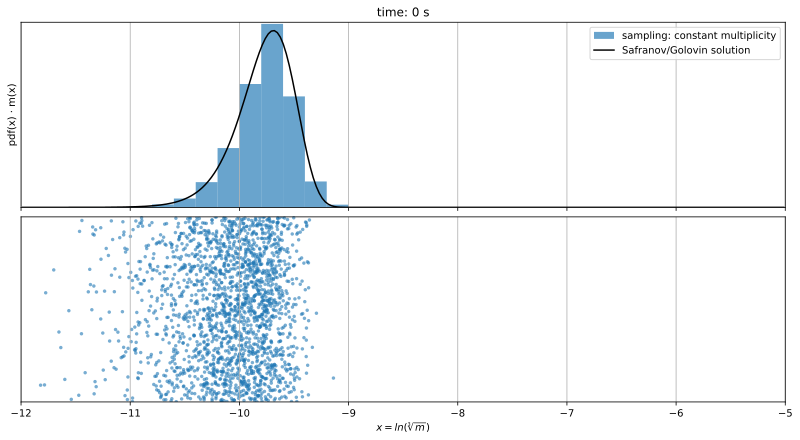

In [6]:
PARTICLES = sample(params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)
plot(step=0,
     output=[PARTICLES],
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_plot=PARAMS_PLOT,
    rng=RNG,
)
show_plot()

### 6. [Algorytm SDM](https://arxiv.org/abs/physics/0701103) - Shima et al. 2007 ([patent z 2006](https://patents.google.com/patent/EP1847939A3))

In [7]:
def sdm(*, pairs, u01, mult, mass, kern, dt, dv):
    """ performs Monte-Carlo coagulation using the SDM algorithm """
    p_scale = len(mult) * (len(mult) - 1) / 2 / len(pairs)
    for alpha, (j, k) in enumerate(pairs):
        if mult[j] < mult[k]:
            j, k = k, j
        p_alpha = mult[j] * p_scale * kern(mass[j], mass[k]) * dt / dv
        gamma = p_alpha // 1 + (p_alpha - p_alpha // 1) > u01[alpha]
        if gamma != 0:
            gamma = min(gamma, (mult[j] / mult[k]) // 1)
            if mult[j] - gamma * mult[k] > 0:
                mult[j] -= gamma * mult[k]
                mass[k] += gamma * mass[j]
            else:
                mult[j] = mult[k] // 2
                mult[k] -= mult[j]
                mass[k] += gamma * mass[j]
                mass[j] = mass[k]

### 8. Wizualizacja

In [8]:
def simulate(*, particles, params_phys, params_comp, rng):
    """ does simulation for all sampling variants (each variant using the same shuffled numbers) """
    n_pairs = params_comp.n_part // 2
    kern = partial(kernel, coeff=params_phys.b_per_s)
    output = [deepcopy(particles)]
    for step in range(1, params_comp.n_step + 1):
        non_overlapping_pairs = rng.permutation(params_comp.n_part)[: 2 * n_pairs].reshape(-1, 2)
        u01 = rng.uniform(0, 1, n_pairs)
        for key, part in particles.items():
            sdm(
                pairs=non_overlapping_pairs,
                u01=u01,
                kern=kern,
                dt=params_comp.dt_s,
                dv=params_phys.dv_m3,
                **part
            )
        if step % params_comp.output_step == 0:
            output.append(deepcopy(particles))
    return output

In [9]:
OUTPUT = simulate(particles=PARTICLES, params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)


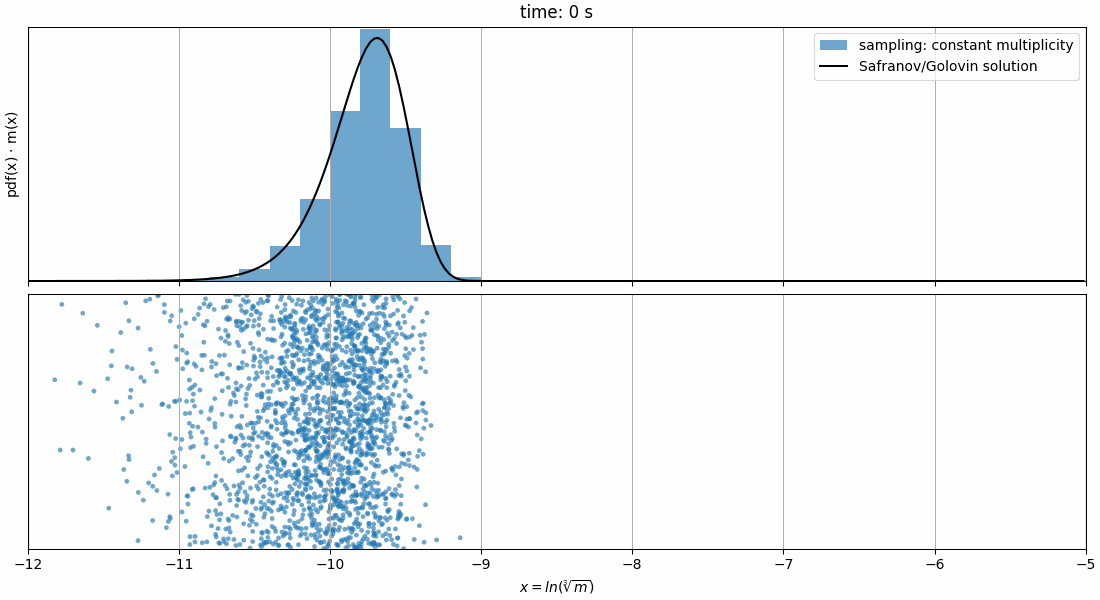

HTML(value="<a href='./tmp03td0bir.gif' target='_blank'>./tmp03td0bir.gif</a><br>")

In [10]:
plot_func = partial(plot,
    output=OUTPUT,
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_plot=PARAMS_PLOT,
    rng=RNG,
)
show_anim(plot_func, frame_range=np.arange(len(OUTPUT)))

### 9. Stan końcowy

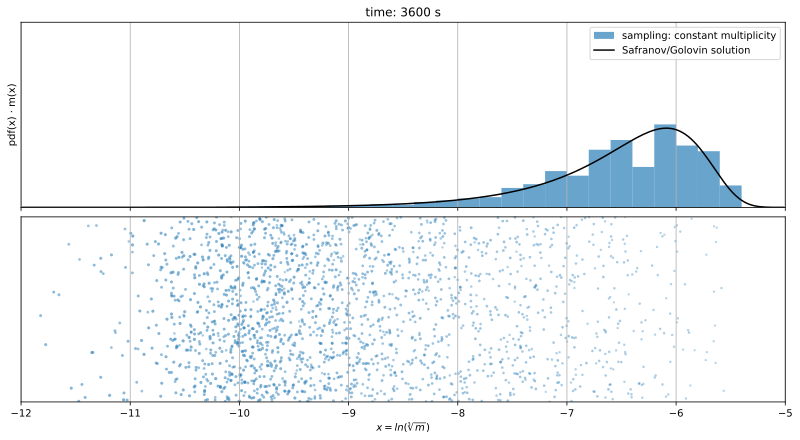

In [11]:
plot(step=PARAMS_COMP.n_step // PARAMS_COMP.output_step,
     output=OUTPUT,
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_plot=PARAMS_PLOT,
    rng=RNG,
)
show_plot()